### Pre-trained segmentation model developed by Facebook Meta AI

Reference:

    https://segment-anything.com/

    https://github.com/facebookresearch/segment-anything

    https://github.com/facebookresearch/segment-anything/tree/main/notebooks

    https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35

Download pre-trained model from:

    https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Other models are available:

    https://github.com/facebookresearch/segment-anything#model-checkpoints


Notebook reference:

    https://www.youtube.com/watch?v=fVeW9a6wItM

In [1]:
first_time_init = False

In [2]:
import torch
import torchvision

print("PyTorch version: ", torch.__version__)
print("TorchVision version: ", torchvision.__version__)
print("CUDA: ", torch.cuda.is_available())

PyTorch version:  2.1.0+cu118
TorchVision version:  0.16.0+cu118
CUDA:  True


The code requires `python>=3.8`, as well as `pytorch>=1.7` and `torchvision>=0.8`. Please follow the instructions here to install both PyTorch and TorchVision dependencies. Installing both PyTorch and TorchVision with CUDA support is strongly recommended.

Install Segment Anything Model Repo

In [3]:
import sys

if first_time_init == True:
  !{sys.executable} -m pip install opencv-python matplotlib
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Load pre-trained model sam_vit_h_4b8939

In [4]:
if first_time_init == True:
  ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [5]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

sys.path.append("..") # adding the parent directory of the current directory to the Python path
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
def resize_image_with_aspect_ratio(image, width = None, height = None, inter = cv2.INTER_AREA):
    scl = 0
    (h, w) = image.shape[0], image.shape[1]

    if (width is None) and (height is None):
      raise ValueError("Please set a value for one of width or height parameters")
    elif height is None:
        # Calculate aspect ratio
        ratio = width / float(w)
        scl = (width, int(h * ratio))
    else:
        # Calculate aspect ratio
        ratio = height / float(h)
        scl = (int(w * ratio), height)

    # Resize the image
    resized = cv2.resize(image, scl, interpolation = inter)

    return resized

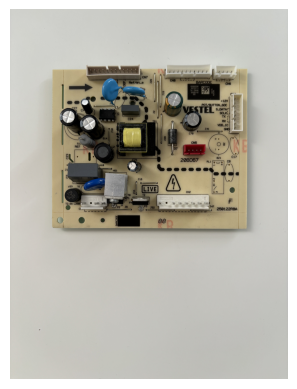

In [7]:
original_image = cv2.imread('/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/IMG_9110.JPG')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.axis('off')
plt.show()

In [8]:
print("image.shape before resizing: ", original_image.shape)
image = resize_image_with_aspect_ratio(original_image, width=1400)
print("image.shape after resizing: ", image.shape)

image.shape before resizing:  (5712, 4284, 3)
image.shape after resizing:  (1866, 1400, 3)


In [9]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device="cuda"

In [10]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

Create model

In [11]:
mask_generator = SamAutomaticMaskGenerator(model=sam,
                                           points_per_side=32,
                                           pred_iou_thresh=0.88,
                                           stability_score_thresh=0.95,
                                           crop_n_layers=1,
                                           crop_n_points_downscale_factor=2,
                                           min_mask_region_area=100)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

* segmentation : the mask
* area : the area of the mask in pixels
* bbox : the boundary box of the mask in XYWH format
* predicted_iou : the model's own prediction for the quality of the mask
* point_coords : the sampled input point that generated this mask
* stability_score : an additional measure of mask quality
* crop_box : the crop of the image used to generate this mask in XYWH format

In [12]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2509 MiB |   2509 MiB |   2509 MiB |      0 B   |
|       from large pool |   2499 MiB |   2499 MiB |   2499 MiB |      0 B   |
|       from small pool |     10 MiB |     10 MiB |     10 MiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |   2509 MiB |   2509 MiB |   2509 MiB |      0 B   |
|       from large pool |   2499 MiB |   2499 MiB |   2499 MiB |

In [13]:
#!pip install numba

Reset GPU memory

In [14]:
#from numba import cuda

#device = cuda.get_current_device()
#device.reset()

In [15]:
masks = mask_generator.generate(image)

In [16]:
print(len(masks))
print(masks[0].keys())

121
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [17]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [18]:
def get_masked_area(masks, mask_id):
  seg_area = np.zeros((masks[mask_id]['segmentation'].shape[0], masks[mask_id]['segmentation'].shape[1], 4))
  seg_area[:,:,3] = 1
  color_mask = np.concatenate([np.random.random(3), [0.35]])
  seg_area[masks[mask_id]['segmentation']] = color_mask
  return seg_area

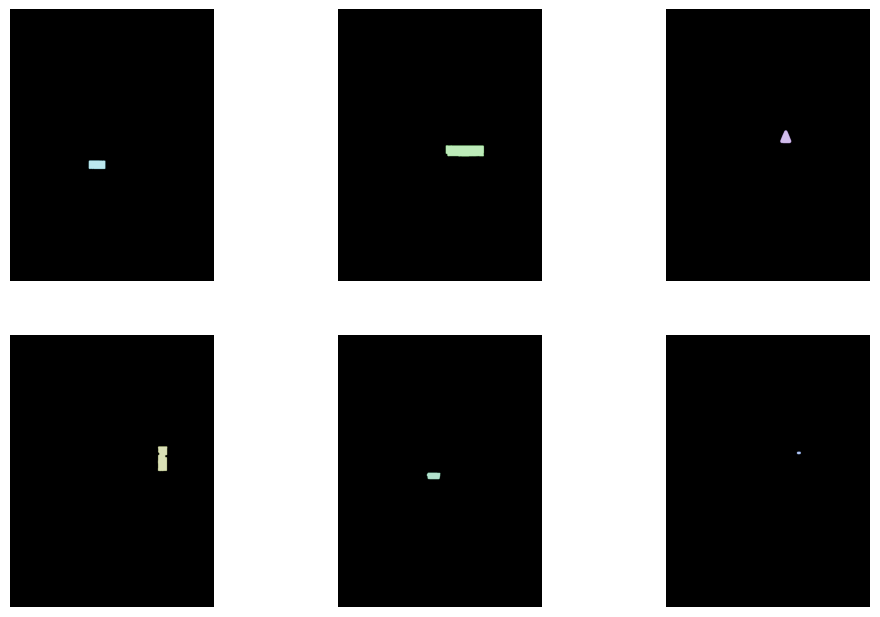

In [19]:
plt.figure(figsize=(12, 12))

for i in range(6):
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(get_masked_area(masks, i))
  plt.axis("off")

plt.show()

Number of pixels that contain True value (White area of the mask)

In [21]:
len(np.where(masks[0]['segmentation'] == True)[0])

6373

Maximum segmented area (Generally background)

In [22]:
max_masked_area_ix = 0
max_area = 0

for ix in range(len(masks)):
  if masks[ix]['area'] > max_area:
    max_area = masks[ix]['area']  # len(np.where(masks[ix]['segmentation'] == True)[0])
    max_masked_area_ix = ix

In [23]:
max_masked_area_ix

118

In [27]:
def show_segmented_samples(masks, image=None, n_row_samples=2):
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    color_mask = np.concatenate([np.random.random(3), [0.35]])
    img[sorted_masks[1]['segmentation']] = color_mask
    ax.imshow(img)
    plt.axis("off")

    plt.show()

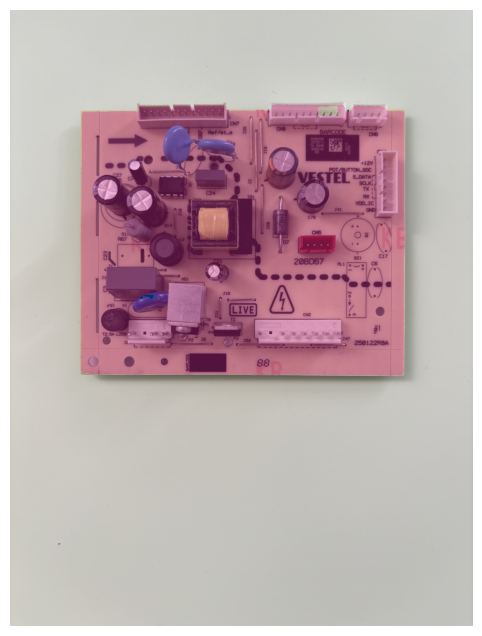

In [28]:
show_segmented_samples(masks, image)

In [30]:
'''
def show_segmented_samples(masks, image=None, n_row_samples=2):
    plt.figure(figsize=(8,8))
    plt.imshow(image)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    for i in range(n_row_samples**2):
      img = np.ones((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1], 4))
      img[:,:,3] = 0
      ax = plt.subplot(n_row_samples, n_row_samples, i + 1)
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[masks[i]['segmentation']] = color_mask
      ax.imshow(img)
      plt.axis("off")

    plt.show()
'''

'\ndef show_segmented_samples(masks, image=None, n_row_samples=2):\n    plt.figure(figsize=(8,8))\n    plt.imshow(image)\n\n    ax = plt.gca()\n    ax.set_autoscale_on(False)\n\n    for i in range(n_row_samples**2):\n      img = np.ones((masks[0][\'segmentation\'].shape[0], masks[0][\'segmentation\'].shape[1], 4))\n      img[:,:,3] = 0\n      ax = plt.subplot(n_row_samples, n_row_samples, i + 1)\n      color_mask = np.concatenate([np.random.random(3), [0.35]])\n      img[masks[i][\'segmentation\']] = color_mask\n      ax.imshow(img)\n      plt.axis("off")\n\n    plt.show()\n'

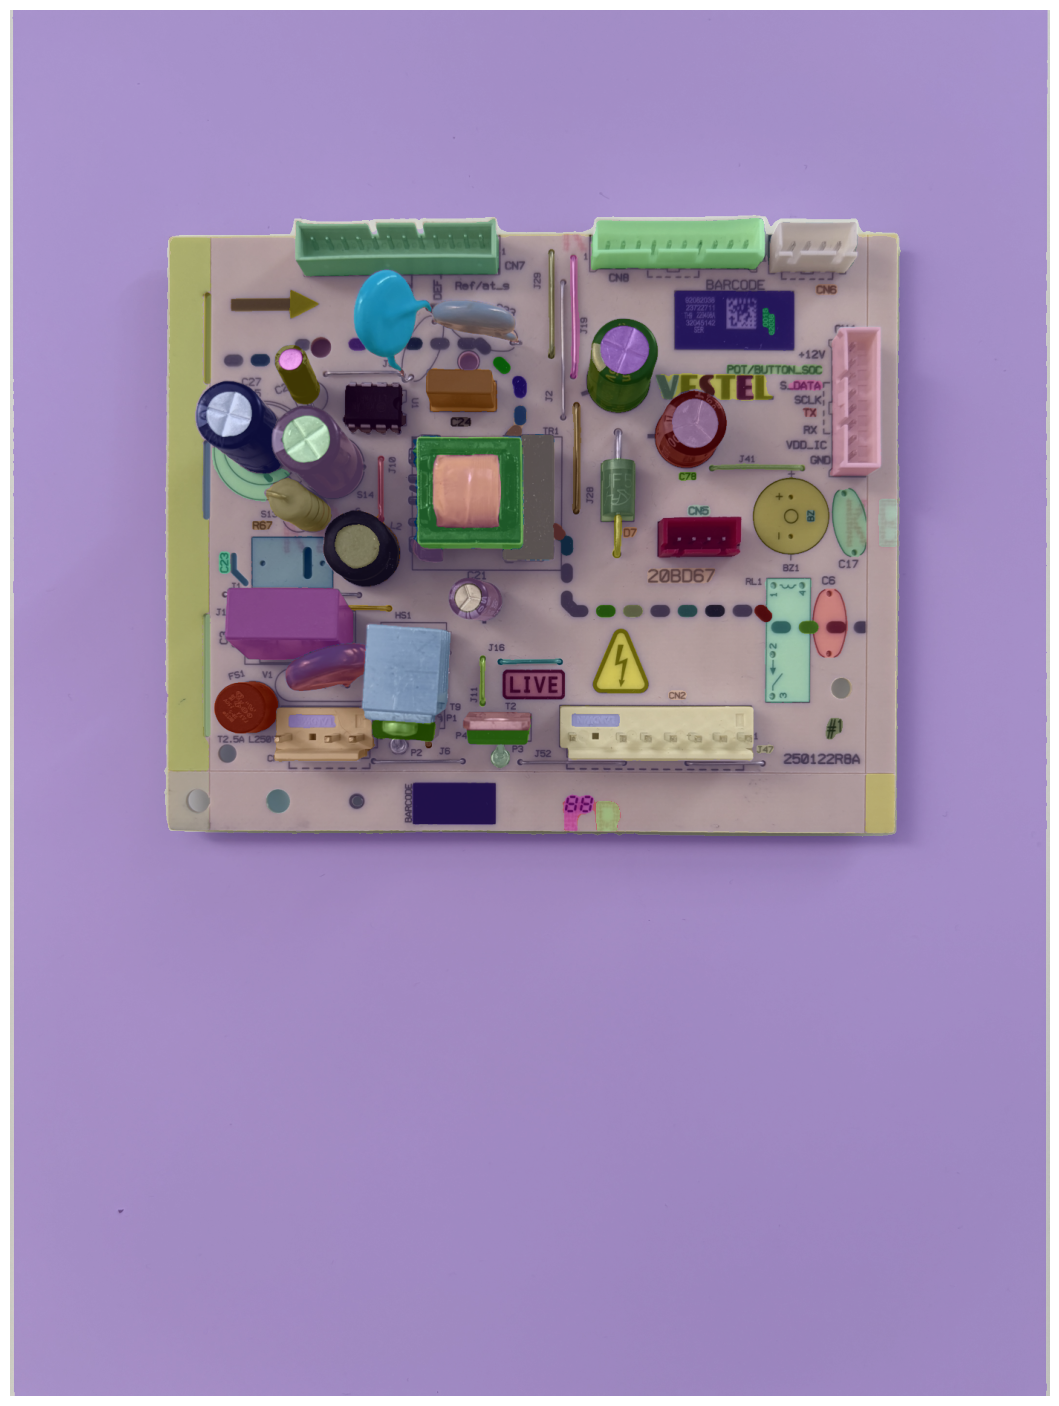

In [31]:
plt.figure(figsize=(18,18))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()